    Let's start by loading the material parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the directory and file for material properties
mysourcedir=os.getcwd()
mydir = os.path.join(os.path.dirname(os.getcwd()), 'polyisobutylene_data')
filename = 'PIB.txt'
filepath = os.path.join(mydir, filename)

# Load the CSV data
data = pd.read_csv(filepath,delimiter='\t')

# Extract G_k and tau_k arrays
tau_k = data.iloc[:, 0].to_numpy()
G_k = data.iloc[:, 1].to_numpy()

# Creating the DataFrame
df = pd.DataFrame({'tau_k': tau_k,'G_k': G_k })

# Sort the DataFrame by tau_k in ascending order
pib = df.sort_values(by='tau_k')

# Print sorted DataFrame
#print(pib)


Now let's define experimental variables

In [2]:
P = 2**12  # sequence length including zero padded values
M = int(P/10) #non-zero values of the relaxation modulus
Delta_t = tau_k[5]/1.0  # timestep
G_e = 0.0  #equlibrium modulus, for PIB assumed zero

Let's load some useful functions from our library

In [8]:
1.0/Delta_t/1.0e6

44.45016127209378

In [9]:
# Define the directory and file for material properties
mylibdir = os.path.join(os.path.dirname(os.getcwd()), 'lib')
os.chdir(mylibdir)

from lib_nls import g_star,func_g,zero_padding,add_noise,dtft_gt_finite,perform_fft,g_hat,nls_fit,g_maxwell_finite,calculate_g_nu,g_hat_ctft


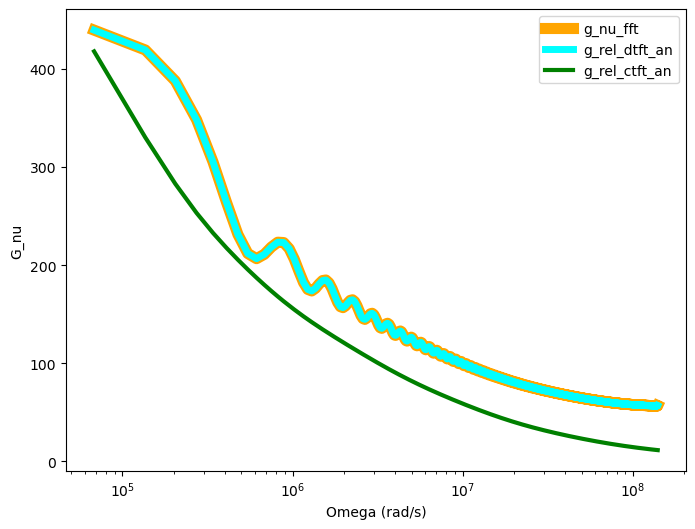

In [10]:
#Simulate relaxation modulus with and without noise
y_n,tn= g_maxwell_finite(P,M,Delta_t,G_k,tau_k,G_e)

g_nu,omega = perform_fft(y_n, Delta_t)  #numerical FFT of input
gnu_ctft = calculate_g_nu(G_e, G_k, tau_k, omega[1::])  #theoretical CTFT (Tschoegl)
dtft,dtft_aliased = dtft_gt_finite(omega[1::], Delta_t, G_k, tau_k, G_e, M)  #theoretical DTFT

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(omega[1::],np.abs(g_nu[1::]), color='orange',lw=8, label='g_nu_fft')
ax.plot(omega[1::],np.abs(dtft), color='cyan',lw=5, label='g_rel_dtft_an')
ax.plot(omega[1::],np.abs(gnu_ctft), color='green',lw=3, label='g_rel_ctft_an')
ax.set_xlabel('Omega (rad/s)')
ax.set_ylabel('G_nu')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend(fontsize=10)
plt.show()


In [5]:
y_n2,tn2 = g_maxwell_finite(M,M,Delta_t,G_k,tau_k,G_e)  #relaxation modulus without zero padding
noise_level = 1.0e7 #1.0e4  # adjust as necessary
y_noise = add_noise(y_n2,noise_level) #noise is added for the simulation trace (added to the non-padded version)
y_noisy = zero_padding(y_noise,P)  #Stress-relaxation for PIB: simulated trace with Gaussian noise

ini_par = {
    'model': func_g,
    'arms': 3,
    'Ge': 0.0,
    'G_i': [1.0e9,1.0e8,1.0e7],  # initial guesses for G1 to G3
    'tau_i': [Delta_t/10.0,Delta_t,Delta_t*10], # initial guesses for tau1 to tau3
    'delta_t':Delta_t,
    'M':M,
    'method_fit':'least_squares'
}

Ge_grel_c, tau_grel_c, G_grel_c, res = nls_fit(tn[1::],y_noisy[1::],**ini_par)

In [12]:
tn[-1]*1.0e6

92.12565000457892

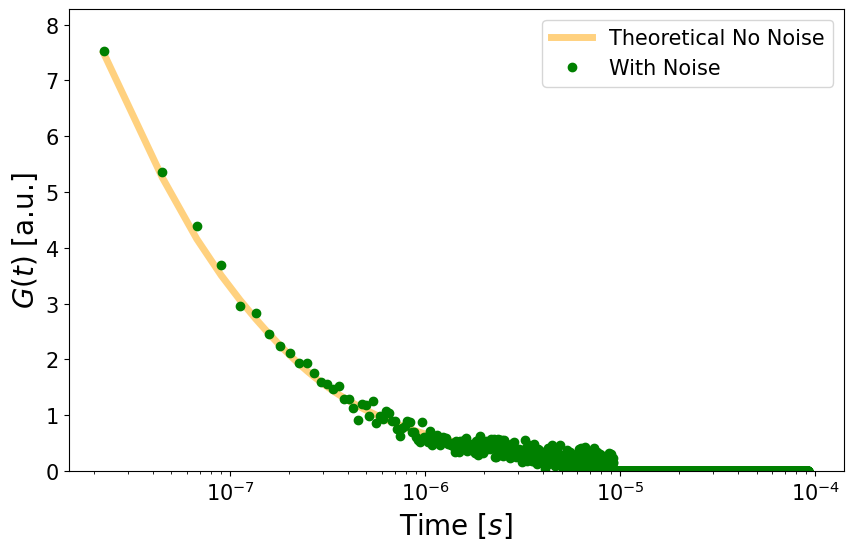

In [15]:
#evaluate Grel for fitted parameters
grel_fit, tn_fit =g_maxwell_finite(P,M,Delta_t,G_grel_c,tau_grel_c,Ge_grel_c)



from matplotlib import rcParams

rcParams['font.size'] = 15   # Set global font size

# Plot the relaxation modulus with and without noise
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tn[1:-1], y_n[1:-1]/1.0e8, label='Theoretical No Noise', color='orange', lw=5, alpha=0.5)
ax.plot(tn[1:-1], y_noisy[1:-1]/1.0e8, 'o', label='With Noise', color='green', lw=3)
#ax.plot(tn_fit[1:-1], grel_fit[1:-1], label='NLS fit', color='red', linestyle='dashed', lw=3)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Time [$s$]',fontsize=20)  # Math text in dollar signs
ax.set_ylabel('$G(t)$ [a.u.]',fontsize=20)  # Math text in dollar signs
ax.legend(fontsize=15)
ax.set_ylim(y_noisy[-1]*0.1/1.0e8,y_noisy[1]*1.1/1.0e8)
plt.show()

# Save figure
os.chdir(mysourcedir)
fig.savefig('RelaxationModulusNoise.png', bbox_inches='tight')


In [7]:
g_nu,omega = perform_fft(y_noisy, Delta_t)  #numerical FFT of input
dtft,_ = dtft_gt_finite(omega[1::], Delta_t, G_k, tau_k, G_e, M)  #theoretical DTFT


ctft = calculate_g_nu(G_e, G_k, tau_k, omega) #theoretical CTFT

ini_par_dtft = ini_par.copy()  # This creates a shallow copy of the ini_par dictionary
ini_par_dtft['model'] = g_hat


Ge_dtft_fit, tau_dtft_fit, G_dtft_fit, res_dtft= nls_fit(omega,g_nu, **ini_par_dtft)

ini_par_ctft = ini_par.copy()  # This creates a shallow copy of the ini_par dictionary
ini_par_ctft['model'] = g_hat_ctft

Ge_ctft_fit, tau_ctft_fit, G_ctft_fit, res_ctft= nls_fit(omega[1:-1],g_nu[1:-1], **ini_par_ctft)

dtft_fit,_ = dtft_gt_finite(omega, Delta_t, G_dtft_fit, tau_dtft_fit, Ge_dtft_fit, M)  #theoretical DTFT



C:\Users\quiqu\OneDrive\Documents\github_enrique\DTFT_Viscoelasticity\lib\lib_nls.py:30: RuntimeWarning: invalid value encountered in true_divide
  G_nu = G_e / (1j * omega) +np.sum([G_k[i] * tau_k[i] / (1 + 1j * omega * tau_k[i]) for i in range(len(G_k))],axis=0)
C:\Users\quiqu\OneDrive\Documents\github_enrique\DTFT_Viscoelasticity\lib\lib_nls.py:298: RuntimeWarning: invalid value encountered in true_divide
  term1 = G_e * (1 - np.exp(-1j * M * omega * Delta_t)) / (1 - np.exp(-1j * omega * Delta_t))
C:\Users\quiqu\OneDrive\Documents\github_enrique\DTFT_Viscoelasticity\lib\lib_nls.py:62: RuntimeWarning: divide by zero encountered in true_divide
  third_term = Ge / (1 - np.exp(-1j * omega * delta_t))
C:\Users\quiqu\OneDrive\Documents\github_enrique\DTFT_Viscoelasticity\lib\lib_nls.py:62: RuntimeWarning: invalid value encountered in true_divide
  third_term = Ge / (1 - np.exp(-1j * omega * delta_t))
C:\Users\quiqu\OneDrive\Documents\github_enrique\DTFT_Viscoelasticity\lib\lib_nls.py:63: 

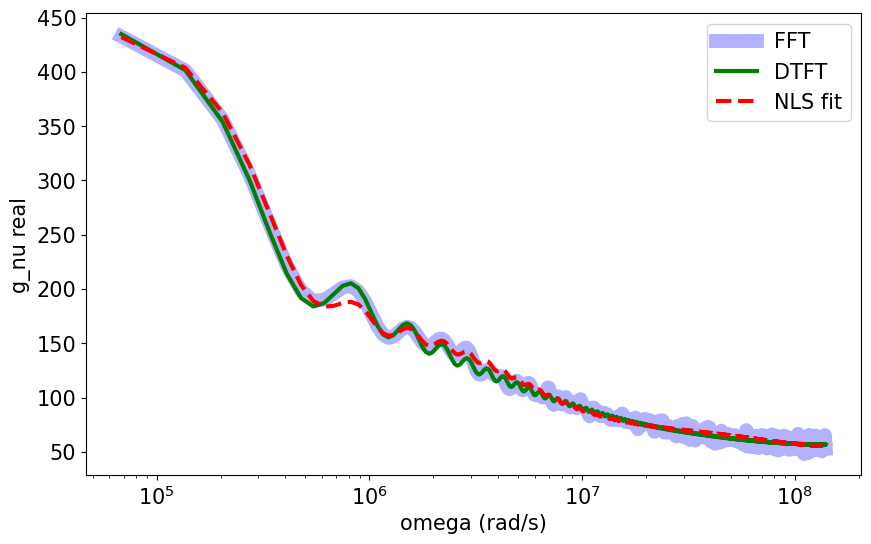

In [8]:
#plot Fourier domain functions and fits
fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(omega[1::],np.abs(ctft[1::]), label='CTFT', color='yellow',lw=5)
ax.plot(omega[1::],np.real(g_nu[1::]), label='FFT',color='blue',lw=10,alpha=0.3)
ax.plot(omega[1::],np.real(dtft), label='DTFT', color='green',lw=3)
ax.plot(omega[1::],np.real(dtft_fit[1::]), label='NLS fit', color='red',linestyle='dashed',lw=3)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('omega (rad/s)')
ax.set_ylabel('g_nu real')
ax.legend()
plt.show()

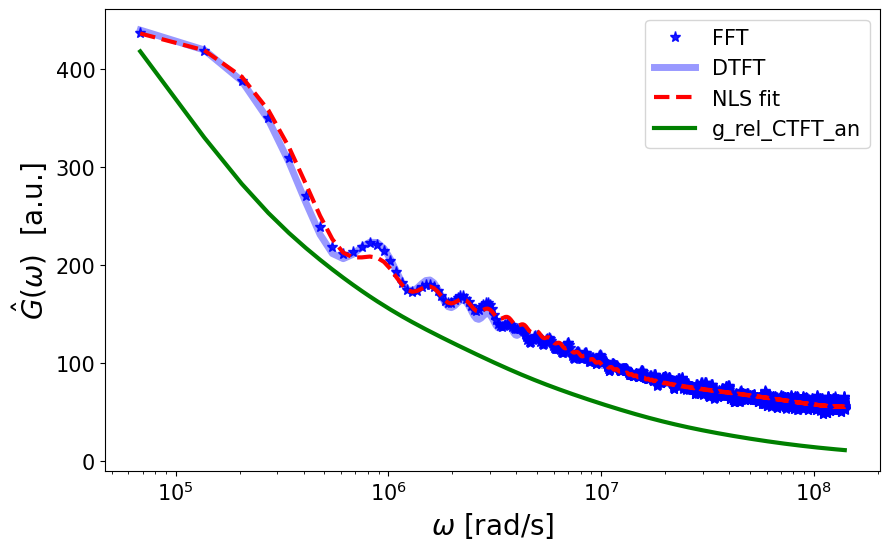

In [18]:
#plot Fourier domain functions and fits
fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(omega[1::],np.abs(ctft[1::]), label='CTFT', color='yellow',lw=5)
ax.plot(omega[1::],np.abs(g_nu[1::]),'*', label='FFT',color='blue',alpha=0.9,ms=8)
ax.plot(omega[1::],np.abs(dtft), label='DTFT', color='blue',lw=5,alpha=0.4)
ax.plot(omega[1::],np.abs(dtft_fit[1::]), label='NLS fit', color='red',linestyle='dashed',lw=3)
ax.plot(omega[1::],np.abs(gnu_ctft), color='green',lw=3, label='g_rel_CTFT_an')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$\omega$ [rad/s]',fontsize=20)
ax.set_ylabel(r'$\hat{G}(\omega)$  [a.u.]',fontsize=20)
ax.legend(fontsize=15)
plt.show()

# Save figure
os.chdir(mysourcedir)
fig.savefig('Fourier_RelaxationModulus.png', bbox_inches='tight')

Calculating Complex Modulus for theoretical and fitted parameters

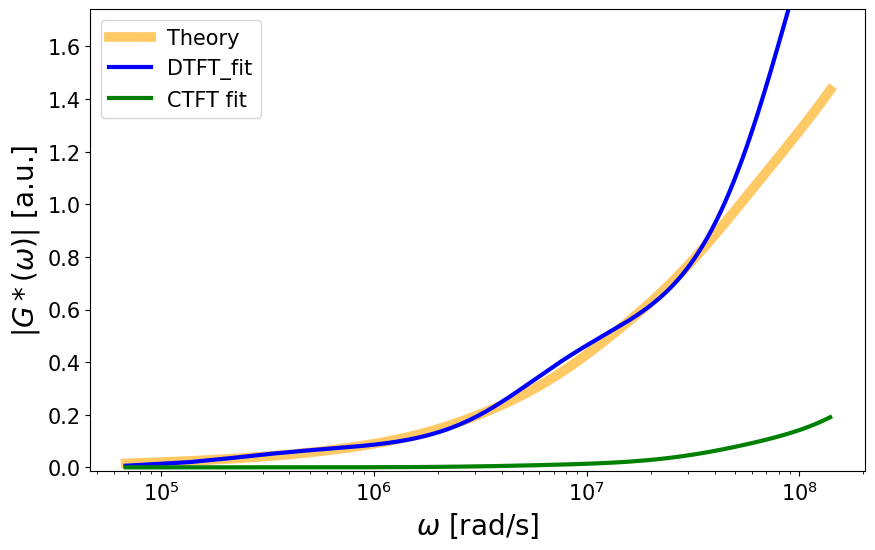

In [19]:
gstar_theory = g_star(omega[1::], G_e, G_k, tau_k)
gstar_dtft = g_star(omega[1::], Ge_dtft_fit, G_dtft_fit, tau_dtft_fit)
gstar_ctft = g_star(omega[1::], Ge_ctft_fit, G_ctft_fit, tau_ctft_fit)
gstar_grel = g_star(omega[1::], Ge_grel_c, G_grel_c, tau_grel_c)

#plot complex modulus
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(omega[1::],np.real(gstar_theory)/1.0e9, label='Theory', color='orange',lw=7,alpha=0.6)
ax.plot(omega[1::],np.real(gstar_dtft)/1.0e9, label='DTFT_fit',color='blue',lw=3)
ax.plot(omega[1::],np.real(gstar_ctft)/1.0e9, label='CTFT fit', color='green',lw=3)
#ax.plot(omega[1::], np.real(gstar_grel)/1.0e9, label='Grel fit', color='red',linestyle='dashed',lw=3)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim(min(np.abs(gstar_theory))*-0.5/1.0e9,max(np.abs(gstar_theory))*1.1/1.0e9)
ax.set_xlabel(r'$\omega$ [rad/s]',fontsize=20)
ax.set_ylabel(r'$|G*(\omega)|$ [a.u.]',fontsize=20)
ax.legend(fontsize=15)
plt.show()

# Save figure
os.chdir(mysourcedir)
fig.savefig('Complex_Modulus_FitvsTheory.png', bbox_inches='tight')

In [17]:
ini_par_ctft

{'model': <function lib_nls.g_hat_ctft(params, omega, G_hat, arms, Delta_t='', M='')>,
 'arms': 3,
 'Ge': 0.0,
 'G_i': [1000000000.0, 100000000.0, 10000000.0],
 'tau_i': [2.24971062282244e-09, 2.24971062282244e-08, 2.24971062282244e-07],
 'delta_t': 2.24971062282244e-08,
 'M': 409,
 'method_fit': 'least_squares'}